In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import XYZ_to_Lab, delta_E, XYZ_to_RGB, RGB_to_XYZ
from colour.models import RGB_COLOURSPACE_sRGB
import tifffile
import zarr
from colour_lib.circle_process.rawparser import RawDataParser
from colour_lib.circle_process.circlelib import *
from colour.models.rgb import RGB_COLOURSPACES, RGB_to_XYZ

# Download features

In [2]:
global_dir = "/uftp/src/"
rw = RawDataParser(reference_basepath=f"{global_dir}calibration_data/")
SRGB_COLSPACE = RGB_COLOURSPACES["sRGB"]

In [3]:
def image_read(sector, g1, g2, g3):
    store = tifffile.imread(
        f"{global_dir}palettes/Calib_{sector}_{g1}_{g2}_{g3}_202402.tif", aszarr=True
    )
    zarr_pyramids = zarr.open(store, mode="r")
    image = np.array(zarr_pyramids[3]) / 255
    gammas = [(g1 / 10), (g2 / 10), (g3 / 10)]
    image_revert = apply_gammaCorr(image, gammas)
    return image_revert

In [4]:
def coords_read(sz):
    return pd.read_csv(f"{global_dir}saved_coords/manual/huron0224/{sz}um_coords.csv")

In [5]:
images = {"R1_111": image_read("R1", 10, 10, 10)}
images["R1_111_XYZ"] = RGB_to_XYZ(RGB=images["R1_111"], colourspace=SRGB_COLSPACE)
rads = {
    "4150": 40,
    "1000": 10,
    "750": 6,
    "500": 4,
    "400": 4,
    "300": 2,
    "250": 2,
    "200": 1,
    "150": 1,
    "CA1000": 50,
}
coords = {
    "4150": coords_read(4150),
    "1000": coords_read(1000),
    "750": coords_read(750),
    "500": coords_read(500),
    "400": coords_read(400),
    "300": coords_read(300),
    "250": coords_read(250),
    "200": coords_read(200),
    "150": coords_read(150),
    "CA1000": coords_read("CA1000"),
}

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [6]:
CA = calc_rectangle(images["R1_111"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangles(
    images["R1_111"],
    coords,
    rads,
    zones=["1000", "750", "500", "400", "300", "250", "200", "150"],
)
slide_vals = calc_slide(CA, slide)

/home/gboykov/colour_project/src/colour_lib/circle_process/circlelib.py:66: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
colour_arrays = {
    "exp_srgbs": slide_vals,
    "exp_xyz": RGB_to_XYZ(RGB=slide_vals, colourspace=SRGB_COLSPACE),  # correctted
    "ref_srgbs": rw.get_reference_srgbs(),
    "ref_xyz": rw.get_reference_d65(),
}

# Process

## Regressor

In [9]:
# from sklearn.cross_decomposition import PLSRegression
# reg = PLSRegression(n_components=colour_arrays["exp_srgbs"].shape[-1])
# # reg.fit(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
# reg.fit(colour_arrays["exp_xyz"], colour_arrays["ref_xyz"])
# mod_img = images["R1_111_XYZ"].copy()
# sz = images["R1_111"].shape[:2]
# img_ = mod_img.reshape(-1,3)
# img_ = img_.astype(np.float32)
# img_ = reg.predict(img_)
# images["cor1R1_111"] = XYZ_to_RGB(img_.reshape(sz[0],sz[1],3), SRGB_COLSPACE)
#     # for i, strip in enumerate(mod_img):
#     #     strip = self.reg.predict(strip)
#     #     mod_img[i] = strip.copy()
#     # return np.clip(mod_img, 0, 1)

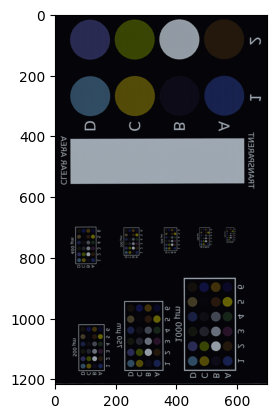

In [8]:
from sklearn.cross_decomposition import PLSRegression

reg = PLSRegression(n_components=colour_arrays["exp_srgbs"].shape[-1])
# reg.fit(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
reg.fit(colour_arrays["exp_xyz"], colour_arrays["ref_xyz"])
mod_img = images["R1_111_XYZ"].copy()
for i, strip in enumerate(mod_img):
    strip = reg.predict(strip)
    mod_img[i] = strip.copy()


mod_img.min()
plt.imshow(mod_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0556581075566..0.764428016473].


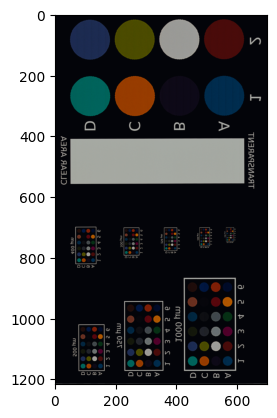

In [9]:
mod_img = np.clip(mod_img, 0, 1)

images["corR1_111_XYZ"] = XYZ_to_RGB(mod_img, SRGB_COLSPACE)
mod_img.min()
plt.imshow(images["corR1_111_XYZ"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0707371947921..1.00456510432].


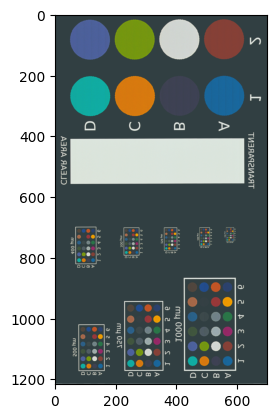

In [10]:
from sklearn.cross_decomposition import PLSRegression

reg = PLSRegression(n_components=colour_arrays["exp_srgbs"].shape[-1])
# reg.fit(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
reg.fit(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
mod_img = images["R1_111"].copy()
for i, strip in enumerate(mod_img):
    strip = reg.predict(strip)
    mod_img[i] = strip.copy()


mod_img.min()
plt.imshow(mod_img)

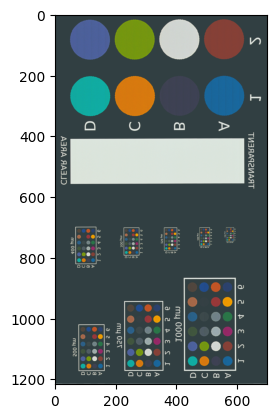

In [14]:
mod_img = np.clip(mod_img, 0, 1)

images["corR1_111_RGB"] = mod_img
mod_img.min()
plt.imshow(images["corR1_111_RGB"])

In [15]:
SRGB_COLSPACE.cctf_encoding(images["corR1_111_XYZ"])

array([[[ 0.12127908,  0.14039498,  0.21077579],
        [ 0.12127908,  0.14039498,  0.21077579],
        [ 0.12127908,  0.14039498,  0.21077579],
        ..., 
        [ 0.1561281 ,  0.19760317,  0.26579863],
        [ 0.16735558,  0.19590428,  0.26644782],
        [ 0.57630831,  0.58526811,  0.59202063]],

       [[ 0.12127908,  0.14039498,  0.21077579],
        [ 0.12127908,  0.14039498,  0.21077579],
        [ 0.12127908,  0.14039498,  0.21077579],
        ..., 
        [ 0.12127908,  0.14039498,  0.21077579],
        [ 0.11643291,  0.14251742,  0.21956691],
        [ 0.57092499,  0.57749541,  0.58029464]],

       [[ 0.12127908,  0.14039498,  0.21077579],
        [ 0.12127908,  0.14039498,  0.21077579],
        [ 0.12127908,  0.14039498,  0.21077579],
        ..., 
        [ 0.11643291,  0.14251742,  0.21956691],
        [ 0.13439885,  0.15201429,  0.21804987],
        [ 0.57092499,  0.57749541,  0.58029464]],

       ..., 
       [[ 0.12127908,  0.14039498,  0.21077579],
        

## Aplication

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.719102749632..0.888284520931].


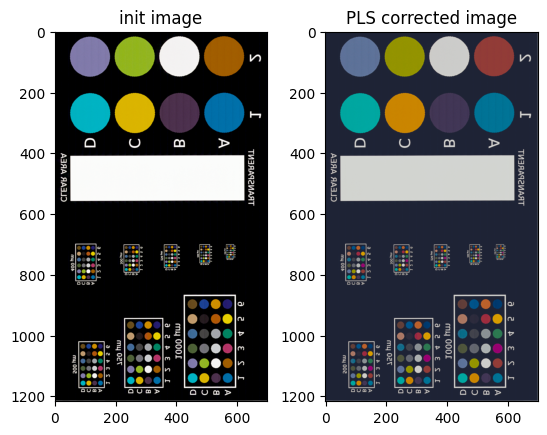

In [13]:
name_list = [["R1_111", "init image"], ["corR1_111_RGB", "PLS RGB"], ["corR1_111_XYZ", "PLS XYX"]]

f, axarr = plt.subplots(1, 2)
for i, vector in enumerate(name_list):
    axarr[i].imshow(SRGB_COLSPACE.cctf_encoding(images[vector[0]]))
    axarr[i].set_title(vector[1])

In [15]:
for i, vector in enumerate(name_list):
    CA = calc_rectangle(images[vector[0]], coords["CA1000"], rads["CA1000"])
    slide = calc_rectangle(images[vector[0]], coords["1000"], rads["1000"])
    colour_arrays[vector[0]] = calc_slide(CA, slide)
    print(
        np.mean(
            calculate_delta_E(
                RGB_to_XYZ(RGB=colour_arrays[vector[0]], colourspace=SRGB_COLSPACE),
                colour_arrays["ref_xyz"],
            )
        )
    )

/home/gboykov/colour_project/src/colour_lib/circle_process/circlelib.py:66: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11.0105951801
4.62988156645
